<a href="https://colab.research.google.com/github/pankosmas/TopicExtractor/blob/main/BERTOPIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation of BERTopic, joblib (downgrade due to cachedir error) and OCTIS 


In [ ]:
# !pip install bertopic[flair]
!pip install bertopic
!pip install scikit-learn
!pip install --upgrade joblib==1.1.0

# Imports everything

In [ ]:
!pip install octis
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.cluster import KMeans
from bertopic import BERTopic
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import hdbscan
import umap
from umap import UMAP 
from hdbscan import HDBSCAN
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

# Read dataset

In [ ]:
stoplist = set('αλλα αλλά εγω εγώ εσυ εσύ αυτος αυτός αυτη αυτή αυτο αυτό εμεις εμείς εσεις εσείς αυτοι αυτοί αυτα '
               'αυτά το του τα των τις τους τοις και ναι οχι μη μην δε λίγο λιγο τόσο τοσο γι για δεν ειμαι είμαι '
               'εισαι είσαι ειναι είναι ειμαστε είμαστε ειστε είστε ειναι είναι ουτε ούτε μητε μήτε ουδε ουδέ η ή '
               'ειτε είτε αν και μα παρα πάρα παρά ομως όμως ωστοσο ωστόσο ενω ενώ μολονοτι μολονότι μονο μόνο μονό '
               'που λοιπον λοιπόν ωστε ώστε αρα άρα επομενως επομένως οποτε όποτε οπότε δηλαδη δηλαδή οτι ότι πως που '
               'μην μηπως μήπως να αμα άμα οταν όταν καθως καθώς αφου αφού αφοτου αφότου πριν μολις προτου ωσπου '
               'ωσοτου σαν γιατι διοτι επειδη αφου τι οτι για να ωστε ως παρα αναμεσα κάνω κάνεις κάνει κάνουν '
               'κάνουμε κι δε μέρα μεταξυ εαν ανω κατω πανω πισω μπρος μπροστα εχω κανω λεω βλεπω μπορω μπορει ισως '
               'καλα καλο καλος καλη καλων έχω έχεις έχει έχουμε έχετε έχουν εχω εχεις εχει εχουμε εχετε εχουν'
               'είχα είχες είχε είχαμε είχατε είχαν ειχα ειχες ειχε ειχαμε ειχατε ειχαν καλους καλε εκει εκτος εντος'
               'μεσα εξω ιδιο ηταν ζωη ολα ολο ολος ολοι ομως ποτε σπανια οποιος οποια οποιο οποιους οποιοι οποιες πολυ πολλα πολλη πολλων πολλους τωρα χθες σημερα '
               'αυριο παρον παρων μελλον παρελθον χθες ωρα χωρις με χρονια πρωτος της κατα στα στο στη στων στις στους '
               'οι ο η απο στην στη στον στο τον την μόλις προτού ώσπου ωσότου σαν γιατί διότι επειδή αφού τι ότι για '
               'να ώστε ως πάρα αναμεσά έχετε κάνετε χθες χτες εχτές εχθές μεταξύ εάν άνω κάτω πάνω πίσω μπρος μπροστά '
               'έχω κάνω λέω βλέπω μπορώ μπορεί ίσως καλά καλό καλός καλή καλών καλούς καλέ εκεί εκτός εντός μέσα έξω '
               'ίδιο ήταν ζωή μεγάλη μικρή όλα όλο όλος όλοι όμως ποτέ σπάνια όποιος όποια όποιο όποιους όποιοι όποιες '
               'πολύ πολλά πολλή πολλών πολλούς τώρα χθες σήμερα αύριο παρόν παρών μέλλον παρελθόν χθες ώρα χωρίς με '
               'χρονιά πρώτος της κατά στα στο μετα μετά όσων οσων στη στων στις στους οι ο η από στην στη στον στο τον την θα όμως σε '
               'αυτού τη όλους μας σας πρέπει ήδη έχει είχε μια μία ένα ένας ενός υπό οποία οποίο οποίος οποίους δικό '
               'μετά κοντά έως εώς άλλους κάτι γύρω πιο όσο έχουν μπορώ μπορεί μπορείτε μπορούν πάνε κάντε δικό θέλετε '
               'δώσετε προς όπως δώστε δει δείτε βλέπω έτσι άλλοι ίδια νέα πολλά κυρίως άλλη ακόμα οποίων επί είπε όχι '
               'μέχρι μου σου του δυο δύο πλέον είπε α β γ δ ε ζ η θ ι κ λ μ ν ξ ο π ρ σ τ υ φ χ ψ ω αυτ όλη όσους '
               'όλες αυτούς θέλω βάζω κάθε κά τότε έχουμε θέλει έκανε βρίσκεται ακόμη όπου φέτος πέρσι μετά πέρυσι '
               'πήρε έδωσε ης βγει νέος νέα νέοι νέους νέας νέων ος γίνει υπάρχει υπάρχω υπάρχουν πάλι θέμα πώς μια μία μιας'
               'ανεξαρτήτως ίδιος μάλιστα έναν έγινε άλλο τρία τρια τρείς τρεις πέντε έξι επτά οκτώ δέκα τέσσερις θεμα'
               'ετ κεδ εναντίον τέσσερα αε ίδιες σ ς εννέα εννιά αο γς τέλος πάντως επίσης ας πχ x εκ περί αυτές άλλων'.split(' '))

s2 = set([word.upper() for word in stoplist])
s3 = set([word.capitalize() for word in stoplist])

stoplist = stoplist.union(s2)
stoplist = stoplist.union(s3)

In [ ]:
def text_length(text):
  text = text.split()
  return len(text)

In [ ]:
texts = df['ptext'].tolist()

385.04767143381


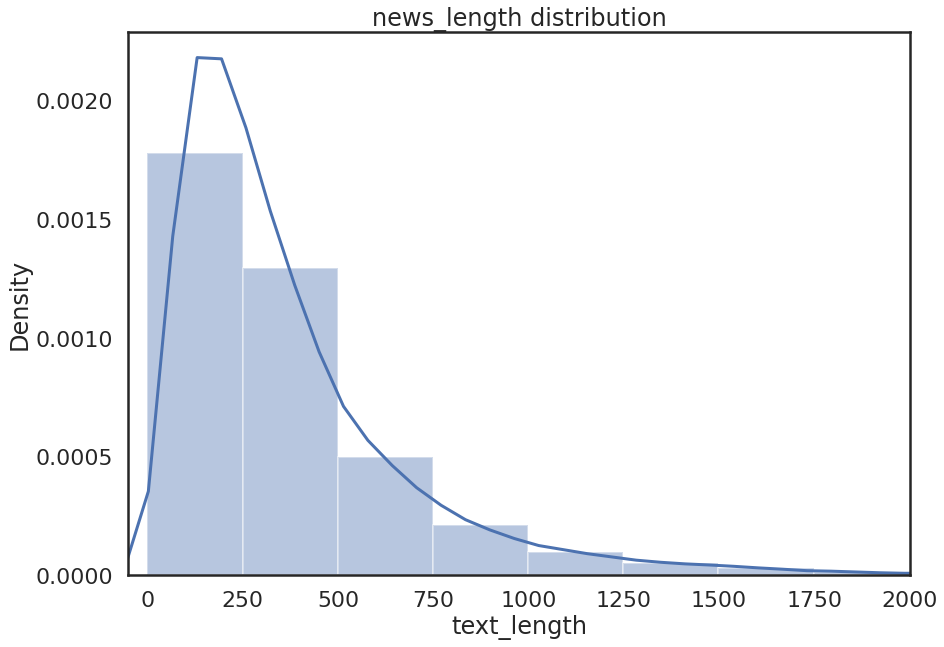

In [ ]:
df['text_length'] = df['ptext'].apply(text_length)
sns.distplot(df['text_length']).set_title('news_length distribution')
plt.xlim(-50, 2000)
print(df['text_length'].mean())

45.028308170515096


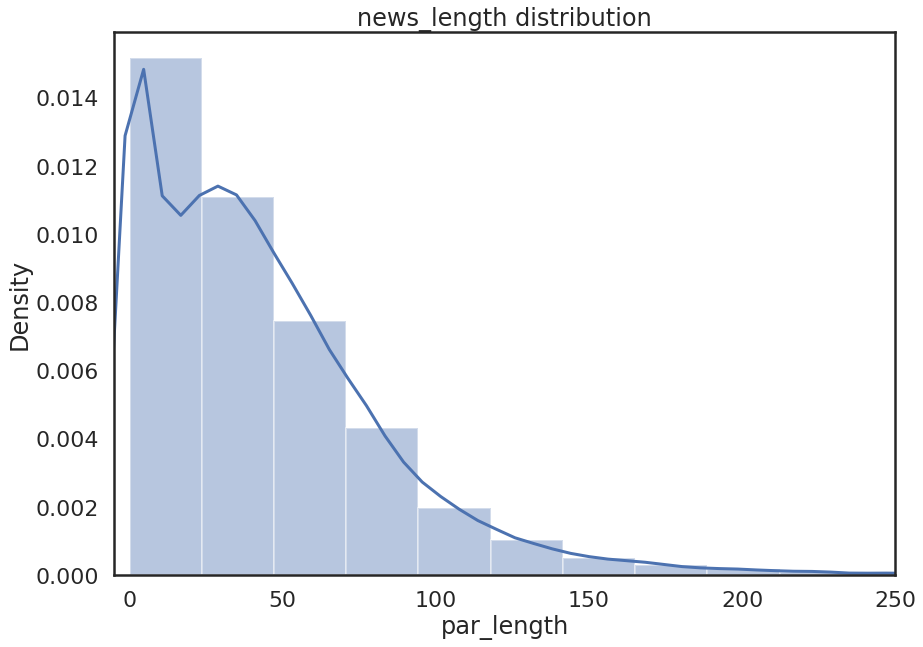

In [ ]:
df_par = pd.DataFrame(new_texts, columns=['pars'])
df_par['par_length'] = df_par['pars'].apply(text_length)
sns.distplot(df_par['par_length']).set_title('news_length distribution')
plt.xlim(-5, 250)
print(df_par['par_length'].mean())

In [ ]:
print(len(texts))
print(len(new_texts))

3509
99088


# Calculate embeddings

In [ ]:
sentence_model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")  # lighteternal/stsb-xlm-r-greek-transfer , paraphrase-multilingual-MiniLM-L12-v2 , paraphrase-multilingual-mpnet-base-v2
embeddings = sentence_model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/2045 [00:00<?, ?it/s]

# UMAP visualization for parameters

In [ ]:
!pip install datashader
!pip install bokeh
!pip install holoviews
!pip install scikit-image
!pip install colorceti

In [ ]:
import umap.plot
categories = df['category'].tolist()
for n in [0.0,0.1,0.25,0.5,0.8,0.99]:
  mapper = umap.UMAP(n_neighbors=20, n_components=2, metric='cosine', min_dist=n).fit(embeddings)
  umap.plot.points(mapper, labels=df['category'], theme='fire', show_legend=False)

In [ ]:
umap.plot.output_notebook()

In [ ]:
hover_data = pd.DataFrame({'index': np.arange(63377), 'label': df['category'], 'text': df['ptext']})
p = umap.plot.interactive(mapper, labels=df['category'], theme='fire', hover_data=hover_data, point_size=2)
umap.plot.show(p)

# Calculate DBCV score for best HDBSCAN params

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
umap_emb = umap_model.fit_transform(embeddings)

In [ ]:
hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(umap_emb)

# specify parameters and distributions to sample from
param_dist = {
              'min_cluster_size':[5, 10, 15, 30, 50, 100, 300, 500, 700, 1000, 2000],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan', 'chebyshev'] 
            }

#validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)


n_iter_search = 20
random_search = RandomizedSearchCV(hdb
                                  ,param_distributions=param_dist
                                  ,n_iter=n_iter_search
                                  ,scoring=validity_scorer 
                                  ,random_state=42)

random_search.fit(umap_emb)
print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

# Train BERTopic Model

In [ ]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# vectorizer_model=vectorizer_model, umap_model=umap_model, hdbscan_model=hdbscan_model
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=list(stoplist), min_df=5, max_df=0.70)
topic_model = BERTopic(vectorizer_model=vectorizer_model, language="greek", calculate_probabilities=False, verbose=True, diversity=0.75)  # .fit_transform(texts)  
topics, probs = topic_model.fit_transform(texts, embeddings)
# topic_model.save("/content/drive/MyDrive/datasets/default_texts_model", save_embedding_model=True)

# Calculate Silhouette Score

In [ ]:
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
# upam_emb με fit_transform απο επανω, εαν δεν δουλευει παμε εδω
# umap_emb = umap_model.transform(embeddings)

umap_emb = umap_model.fit_transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_emb[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
print(silhouette_score(X, labels))

0.52160853


# Calculate coherences and topic diversity

In [ ]:
# Preprocess Documents
documents = pd.DataFrame({"Document": texts,
                          "ID": range(len(texts)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]

# dictionary = corpora.Dictionary(tokens)
# corpus = [dictionary.doc2bow(token) for token in tokens]
# topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

'''
# Evaluate
# c_v
coherence_model = CoherenceModel(topics=topic_words, 
                                texts=tokens, 
                                corpus=corpus,
                                dictionary=dictionary, 
                                coherence='c_v')
coherence = coherence_model.get_coherence()
print('c_v = ', coherence)

# npmi
coherence_model = CoherenceModel(topics=topic_words, 
                              texts=tokens, 
                              corpus=corpus,
                              dictionary=dictionary, 
                              coherence='c_npmi')
coherence = coherence_model.get_coherence()
print('npmi = ', coherence)
'''

"\n# Evaluate\n# c_v\ncoherence_model = CoherenceModel(topics=topic_words, \n                                texts=tokens, \n                                corpus=corpus,\n                                dictionary=dictionary, \n                                coherence='c_v')\ncoherence = coherence_model.get_coherence()\nprint('c_v = ', coherence)\n\n# npmi\ncoherence_model = CoherenceModel(topics=topic_words, \n                              texts=tokens, \n                              corpus=corpus,\n                              dictionary=dictionary, \n                              coherence='c_npmi')\ncoherence = coherence_model.get_coherence()\nprint('npmi = ', coherence)\n"

In [ ]:
topic_words = topic_model.c_tf_idf_

In [ ]:
# top div
output = {'topic-word-matrix': topic_words, 'topics': tokens, 'topic-document-matrix': probs}
t_d = TopicDiversity(topk=10)
t_d_s = t_d.score(output)
print('topic diversity = ', t_d_s)

topic diversity =  0.5206572769953052


In [ ]:
npmi = Coherence(texts=tokens, topk=10, measure='c_npmi')
npmi_s = npmi.score(output)
print('c_npmi = ',npmi_s)

In [ ]:
npmi = Coherence(texts=tokens, topk=10, measure='u_mass')
npmi_s = npmi.score(output)
print('u_mass = ', npmi_s)

In [ ]:
npmi = Coherence(texts=tokens, topk=10, measure='c_uci')
npmi_s = npmi.score(output)
print('c_uci = ', npmi_s)

c_uci =  2.9445161464689162


In [ ]:
npmi = Coherence(texts=tokens, topk=10, measure='c_v')
npmi_s = npmi.score(output)
print('c_v = ', npmi_s)

c_v =  0.6966062535157028


In [ ]:
from octis.evaluation_metrics.similarity_metrics import RBO
from octis.evaluation_metrics.diversity_metrics import KLDivergence, InvertedRBO

In [ ]:
npmi = InvertedRBO()
npmi_s = npmi.score(output)
print('InvertedRBO = ', npmi_s)

In [ ]:
npmi = KLDivergence()
npmi_s = npmi.score(output)
print('KLDivergence = ', npmi_s)

In [ ]:
npmi = RBO()
npmi_s = npmi.score(output)
print('RBO = ', npmi_s)

# Exploring BERTopic API

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,25356,-1_ελλάδα_ομάδα_συριζα_τελευταία
1,0,1621,0_συμβόλαιο_διαβάστε περισσότερα onsports_περι...
2,1,853,1_ελισάβετ_βασίλισσας_βασίλισσα_κάρολος
3,2,519,2_τσιτσιπάς_σετ_wimbledon_τενίστας
4,3,496,3_ερντογάν_τουρκία_τουρκίας_ταγίπ ερντογάν
...,...,...,...
1486,1485,5,1485_ερτ_ζευγαρι_τρ_ριμπ
1487,1486,5,1486_lidl_lidl ελλάς_ελλάς_gold
1488,1487,5,1487_νο_σάκκαρη_ιγκα_μαρία σάκκαρη
1489,1488,5,1488_καζίνο_ελληνικου_irc_γεκ τερνα


In [ ]:
for t in topics:
  print(topic_model.get_topic_info())

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(texts)

100%|██████████| 1489/1489 [00:25<00:00, 57.83it/s]


In [ ]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)